In [156]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')
%matplotlib inline
import sys
from scipy import stats
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn import linear_model
from missingpy import MissForest
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import log_loss
import warnings 
warnings.filterwarnings("ignore")

In [332]:
df = pd.read_csv("data.csv", encoding = "iso-8859-1")

In [333]:
df.head()

,user_id,gender,date_of_birth,workclass,education_level,education_num,marital_status,occupation,relationship,capital_gain,...,hours_per_week,approved,address,email,inquiry_purpose_code,institute_type,account_type,asset_class_cd,asset_code,portfolio_type
0,307c73a3-0c67-43b5-b0d1-62ad5f00b52a,Female,1/3/1987,Private,11th,7,Never-married,Sales,Unmarried,0,...,17,0,"45424 Norris Common Apt. 390\r\nNorth Mike, AR...",vasquezleah@yahoo.com,7.0,PVT,5,NaN,1.0,R
1,519481f1-604d-48b6-aa47-4123a982431a,Male,1/7/1970,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Craft-repair,Husband,0,...,48,0,"5022 Rebecca Haven Apt. 258\r\nThompsonfurt, C...",johnsontrevor@hotmail.com,13.0,NBF,5,NaN,1.0,R
2,f66fe2c6-53e3-46ce-8321-e530b4af1ace,Male,1/6/1973,Private,HS-grad,9,Divorced,Sales,Not-in-family,0,...,50,0,"8780 Brown Loaf Apt. 099\r\nNorth David, NJ 56510",morganemily@gmail.com,13.0,NBF,5,NaN,1.0,R
3,91360ed7-72d1-4f6e-b492-d71ef4480061,Female,12/30/2001,Private,11th,7,Never-married,Sales,Own-child,0,...,15,0,721 Jackson Extensions Suite 995\r\nNew Tarasi...,agarcia@hotmail.com,13.0,NBF,5,NaN,1.0,R
4,0e1977f3-3bef-4283-8d0a-d60b0f6ff480,Male,1/3/1986,Private,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,0,...,50,0,"935 Burch Divide\r\nLake Bobbyfurt, VT 14128",shermanmeredith@gmail.com,13.0,PVT,47,S,1.0,I


In [348]:
df.columns

Index(['user_id', 'gender', 'date_of_birth', 'workclass', 'education_level',
       'education_num', 'marital_status', 'occupation', 'relationship',
       'capital_gain', 'capital_loss', 'hours_per_week', 'approved', 'address',
       'email', 'inquiry_purpose_code', 'institute_type', 'account_type',
       'asset_class_cd', 'asset_code', 'portfolio_type', 'age', 'dob_date',
       'dob_month', 'dob_year', 'address_line1', 'address_line2',
       'address_line3', 'email_domain', 'net_profit'],
      dtype='object')

In [349]:
df["address"].values[0]

'45424 Norris Common Apt. 390 North Mike, AR 83962'

In [334]:
df["approved"].value_counts(normalize = True) #imbalanced dataset

0    0.752156
1    0.247844
Name: approved, dtype: float64

In [335]:
#modifying cell datatype 
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
df["approved"] =df["approved"].astype(object)
df["inquiry_purpose_code"] = df["inquiry_purpose_code"].astype(object)
df["account_type"] = df["account_type"].astype(object)
df["asset_code"] = df["asset_code"].astype(object)

In [336]:
# to split the address into _ , region and zipcode, to see if there is a better based on the geolocation
def split_address(address):
    
    if not address:
        return []
    
    address = address.split(" ")
    
    if len(address) < 3:
        return []
    
    return [" ".join(address[:-2]).replace("\r\n", " ").strip(), address[-2].strip(), address[-1].strip()]

In [337]:
def age(dob):
    today = datetime.today()
    years = today.year - dob.year
    if today.month < dob.month or (today.month == dob.month and today.day < dob.day):
        years -= 1
    return years

In [338]:
#extracting age from date of birth
df["age"] = df.apply(lambda x: age(x["date_of_birth"]), axis = 1)

In [339]:
df["dob_date"] = df.apply(lambda x: x["date_of_birth"].day, axis = 1).astype(object)
df["dob_month"] = df.apply(lambda x: x["date_of_birth"].month, axis = 1).astype(object)
df["dob_year"] = df.apply(lambda x: x["date_of_birth"].year, axis = 1).astype(object)

In [340]:
df["address"] = df.apply(lambda x: split_address(x["address"]), axis = 1)
split_df = pd.DataFrame(df['address'].tolist(), columns=['address_line1', 'address_line2', 'address_line3'])
df = pd.concat([df, split_df], axis=1)
df["address"] = df.apply(lambda x: " ".join(x["address"]), axis = 1)

In [341]:
df["email_domain"] = df.apply(lambda x: x["email"].split("@")[-1] if x["email"] else "", axis = 1)

#there are more than 10k unique email domain, bucketing them into 4 categories
df["email_domain"] = df.apply(lambda x: x["email_domain"] if x["email_domain"] in ["gmail.com", "yahoo.com", "hotmail.com"] else "other", axis = 1)

In [342]:
df["net_profit"] = df.apply(lambda x: x["capital_gain"] - x["capital_loss"] , axis = 1)

In [343]:
#Kernel density estimation plot for continuous variables
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['approved'] == 0][feature], color= 'orange', label= 'No', shade= True)
    ax1 = sns.kdeplot(df[df['approved'] == 1][feature], color= 'blue', label= 'Yes', shade= True)
    plt.plot()

In [344]:
#barplot for categorical variables
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):

    
    g = df.groupby(feature)["approved"].value_counts().to_frame()  
    g = g.rename({"approved": axis_name}, axis=1).reset_index()
    g[axis_name] = (g[axis_name]/len(df))*100   
    

    ax = sns.barplot(x=feature, y= axis_name, hue='approved', data=g, orient=orient)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    ax.plot()
    
    intplan = pd.crosstab(df[feature],df['approved'])
    intplan.div(intplan.sum(1), axis=0).plot(kind='bar', stacked=True)
    
    plt.show()

In [346]:
def chi2_test(df, col1, col2):    
    df_cont = pd.crosstab(index = df[col1], columns = df[col2])
    
    #degree of freedom---
    degree_f = (df_cont.shape[0]-1) * (df_cont.shape[1]-1)
    df_cont.loc[:,'Total']= df_cont.sum(axis=1)
    df_cont.loc['Total']= df_cont.sum()

    #expected value dataframe
    df_exp = df_cont.copy()    
    df_exp.iloc[:,:] = np.multiply.outer(df_cont.sum(1).values,df_cont.sum().values) / df_cont.sum().sum()            
    
    print(df_cont)
    print(df_exp)
    # calculating chi-square values
    df_chi2 = ((df_cont - df_exp)**2) / df_exp    
    df_chi2.loc[:,'Total']= df_chi2.sum(axis=1)
    df_chi2.loc['Total']= df_chi2.sum()
 
    chi_square_score = df_chi2.iloc[:-1,:-1].sum().sum()
    
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)
    
    return chi_square_score, degree_f, p

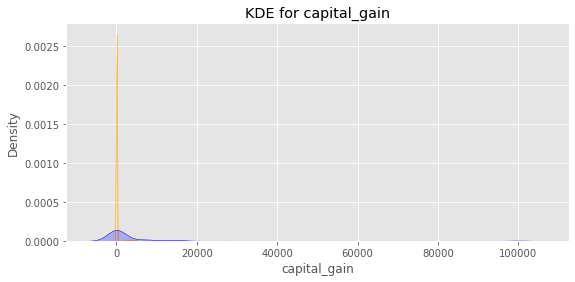

In [171]:
kdeplot("capital_gain")

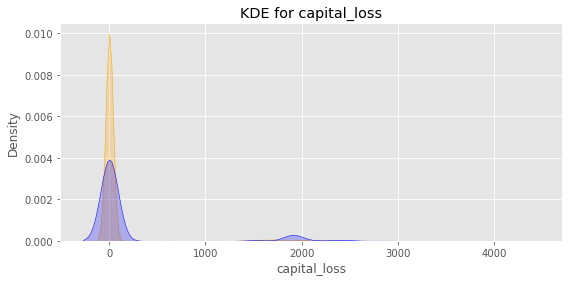

In [172]:
kdeplot("capital_loss")

<AxesSubplot:xlabel='approved', ylabel='capital_loss'>

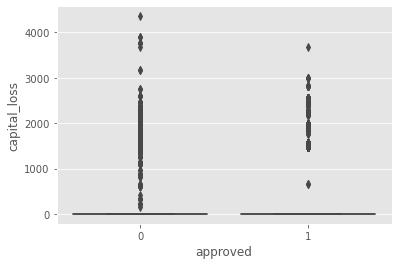

In [173]:
sns.boxplot(x = 'approved', y = "capital_loss", data = df)

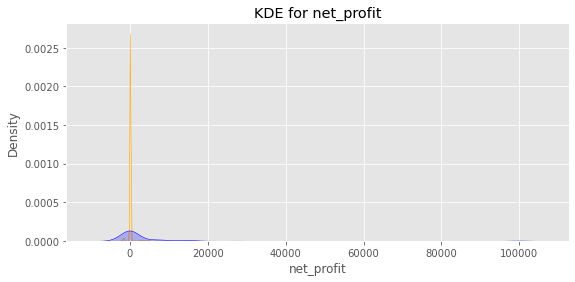

In [174]:
kdeplot("net_profit")

<AxesSubplot:xlabel='approved', ylabel='net_profit'>

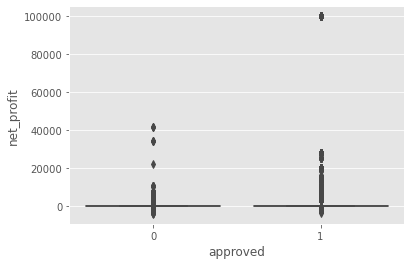

In [175]:
sns.boxplot(x = 'approved', y = "net_profit", data = df)

In [176]:
for i in np.unique(df["occupation"]):
    if i not in np.unique(df[df["net_profit"]> 50000]["occupation"]):
        print(i)

 Armed-Forces
 Priv-house-serv


People with high net profit are more likely to get their credit approved. We can also see some outliers here. Few people have a very high net_profit and their credits have been approved. That high income is spread across 12 occupatioins out of 14 ( i.e except Armed-Forces, Priv-house-serv)

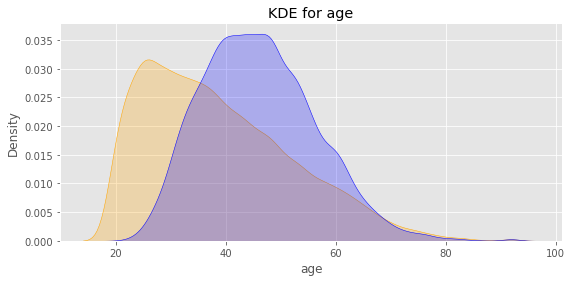

In [177]:
kdeplot("age")

<AxesSubplot:xlabel='approved', ylabel='age'>

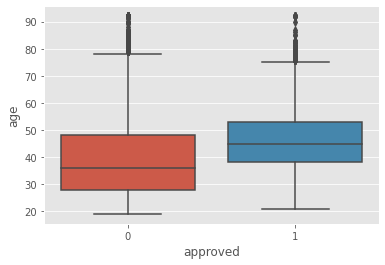

In [178]:
sns.boxplot(x = 'approved', y = "age", data = df)

Based on the above plots it looks like someone with a higher age is more likely to get his/her credit approved. however there are several outlying applicants with high values that still were not granted credit.

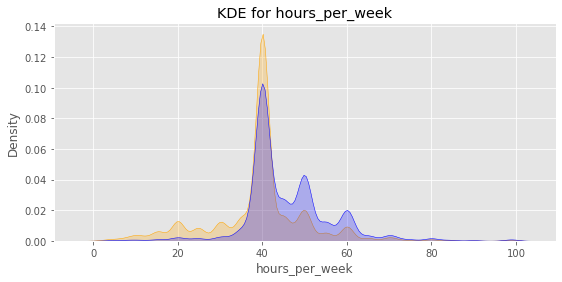

In [179]:
kdeplot("hours_per_week")

<AxesSubplot:xlabel='approved', ylabel='hours_per_week'>

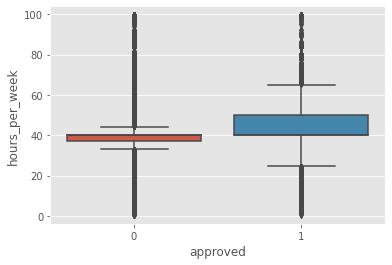

In [180]:
sns.boxplot(x = 'approved', y = "hours_per_week", data = df)

Based on the above plot it looks like someone who is working more number of hours per week is more likely to get his/her credit approved.however there are several outlying applicants with high values that still were not granted credit.

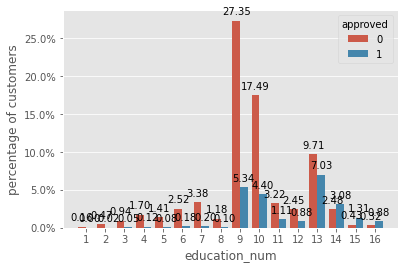

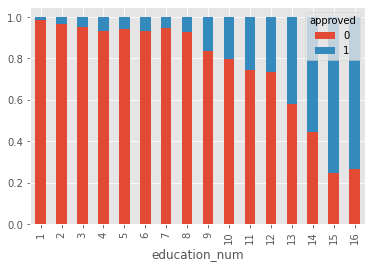

In [181]:
barplot_percentages("education_num")

Based on the above plot it looks like someone with an higher education is more likely to get his/her credit approved

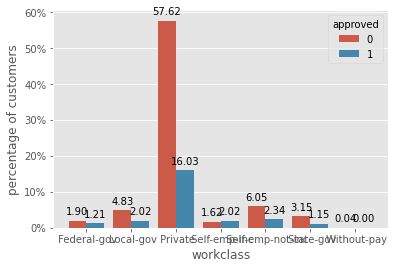

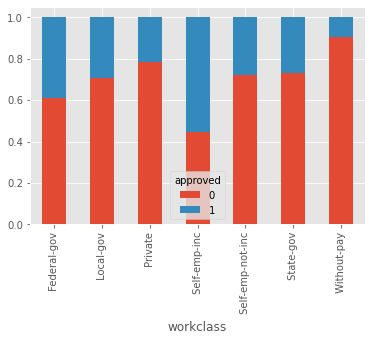

In [182]:
barplot_percentages("workclass")

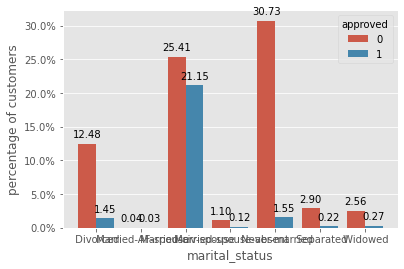

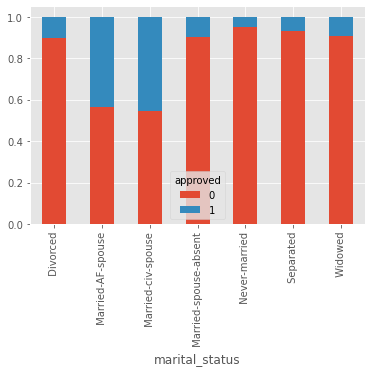

In [183]:
barplot_percentages("marital_status")

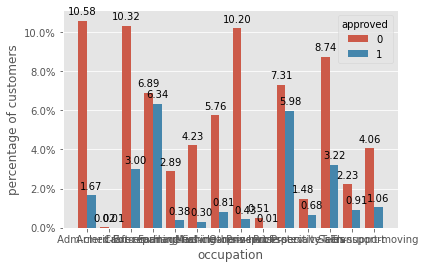

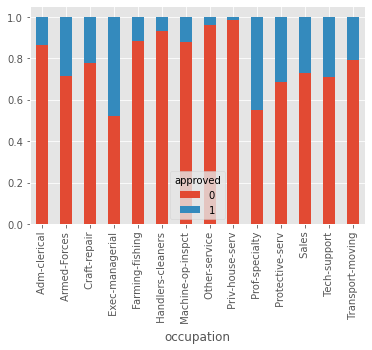

In [184]:
barplot_percentages("occupation")

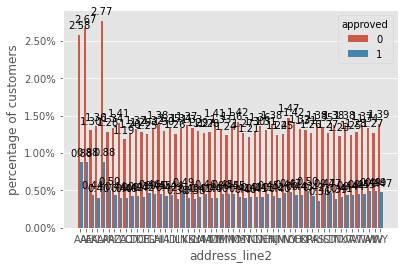

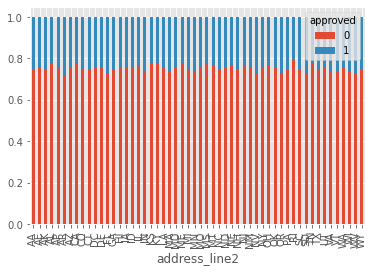

In [185]:
barplot_percentages("address_line2")

In [186]:
chi2_test(df, "address_line2", "approved")

(54.92747394479847, 53, 0.40144556242614193)

p> 0.05, hence uncorrelated

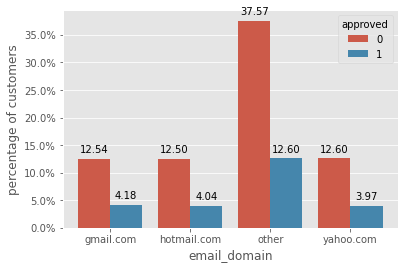

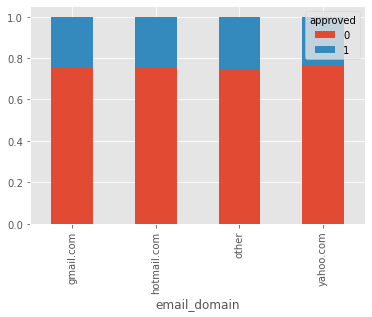

In [187]:
barplot_percentages("email_domain")

In [188]:
chi2_test(df, "email_domain", "approved")

(4.769793542645564, 3, 0.18945121731058318)

p> 0.05, hence uncorrelated

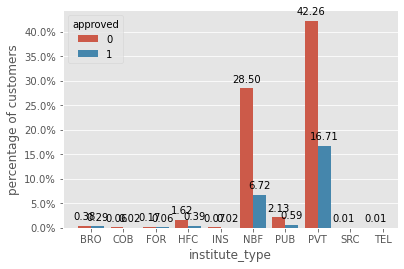

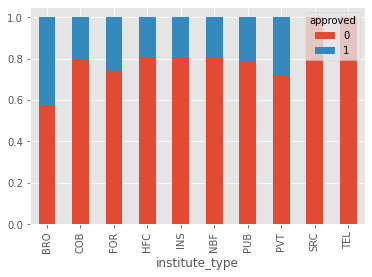

In [189]:
barplot_percentages("institute_type")

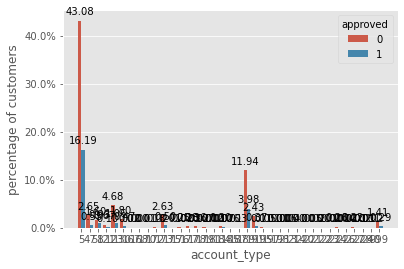

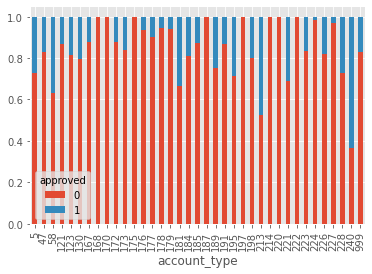

In [190]:
barplot_percentages("account_type")

Certain kind of loans are more likely to get rejected than other, for example 168, 170(microfinance personal and housing) has 100% rejection as compared to 58(Installment loan) and 213(tractor loan)

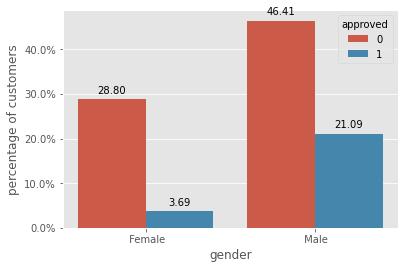

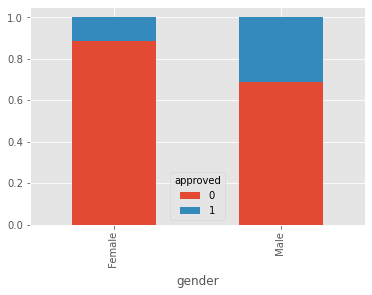

In [191]:
barplot_percentages("gender")

In [192]:
#chi square test to check correlation between gender and  credit approval
chi2_test(df, "gender", "approved")

(2105.2005547176623, 1, 0.0)

p < 0.05, hence gender and credit approval is correlated

The decision to approve or deny an application cannot be based on the applicant's gender. We can clearly see a strong correlation between them in the above plots.

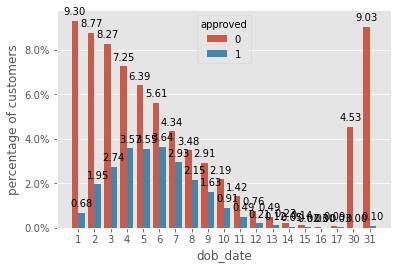

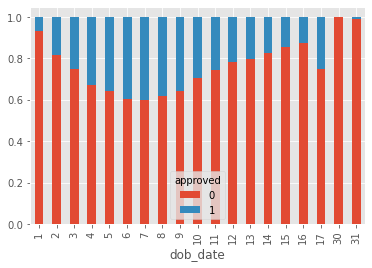

In [193]:
barplot_percentages("dob_date")

In [194]:
chi2_test(df, "dob_date", "approved")

(4593.213302846094, 18, 0.0)

p < 0.05, hence dob_date and credit approval is correlated

The decision to approve or deny an application cannot be based on the applicant's dateof birth. We can clearly see a strong correlation between them in the above plots.

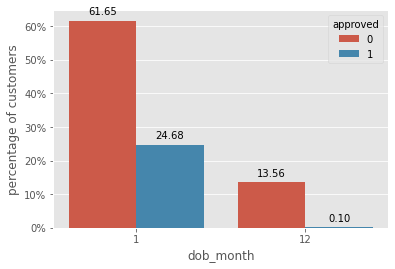

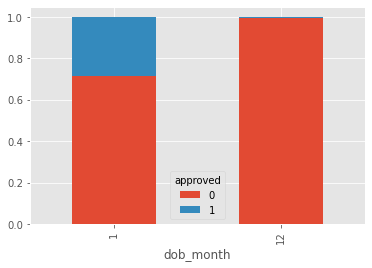

In [195]:
barplot_percentages("dob_month")

In [196]:
chi2_test(df, "dob_month", "approved")

(2221.2841144366485, 1, 0.0)

p < 0.05, hence dob_month and credit approval is correlated

The decision to approve or deny an application cannot be based on the applicant' month of birth. We can clearly see a strong correlation between them in the above plots.

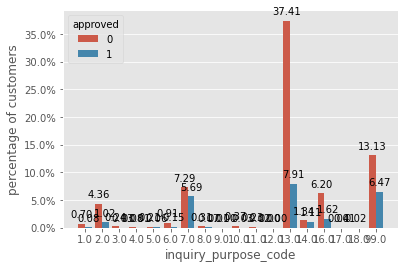

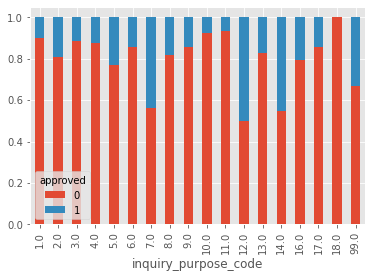

In [197]:
barplot_percentages("inquiry_purpose_code")

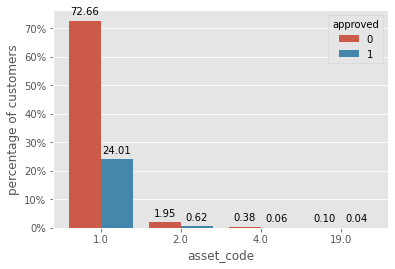

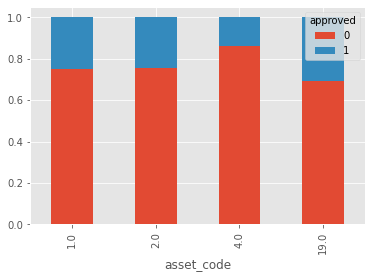

In [198]:
barplot_percentages("asset_code")

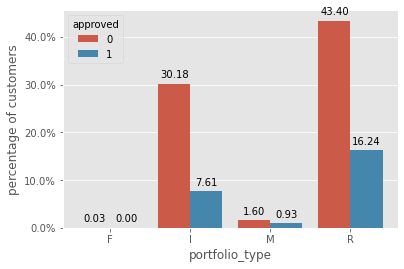

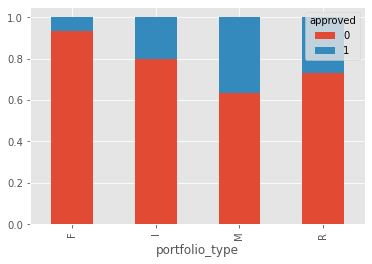

In [199]:
barplot_percentages("portfolio_type")

summarisation of the plots above:
    
1. People with high net profit are more likely to get their credit approved. We can also see some outliers here. Few people have a very high net_profit and their credits have been approved. That high income is spread across 12 occupatioins out of 14 ( i.e except Armed-Forces, Priv-house-serv)
2. someone with a higher age is more likely to get his/her credit approved
3. someone who is working more number of hours per week is more likely to get his/her credit approved
4. someone with an higher education is more likely to get his/her credit approved
5. A self employed person is more likely to get a loan as compared to someone without a pay
6. Married person with a spouse is more likely to get a credit.
7.Certain kind of loans are more likely to get rejected than other, for example 168, 170(microfinance personal and housing) has 100% rejection as compared to 58(Installment loan) and 213(tractor loan)

The decision to approve or deny an application cannot be based on the applicant’s gender, date or month of birth. We can clearly see a strong correlation between them in the above plots and the same has been verified using chi square test

In [200]:
#correlation plot

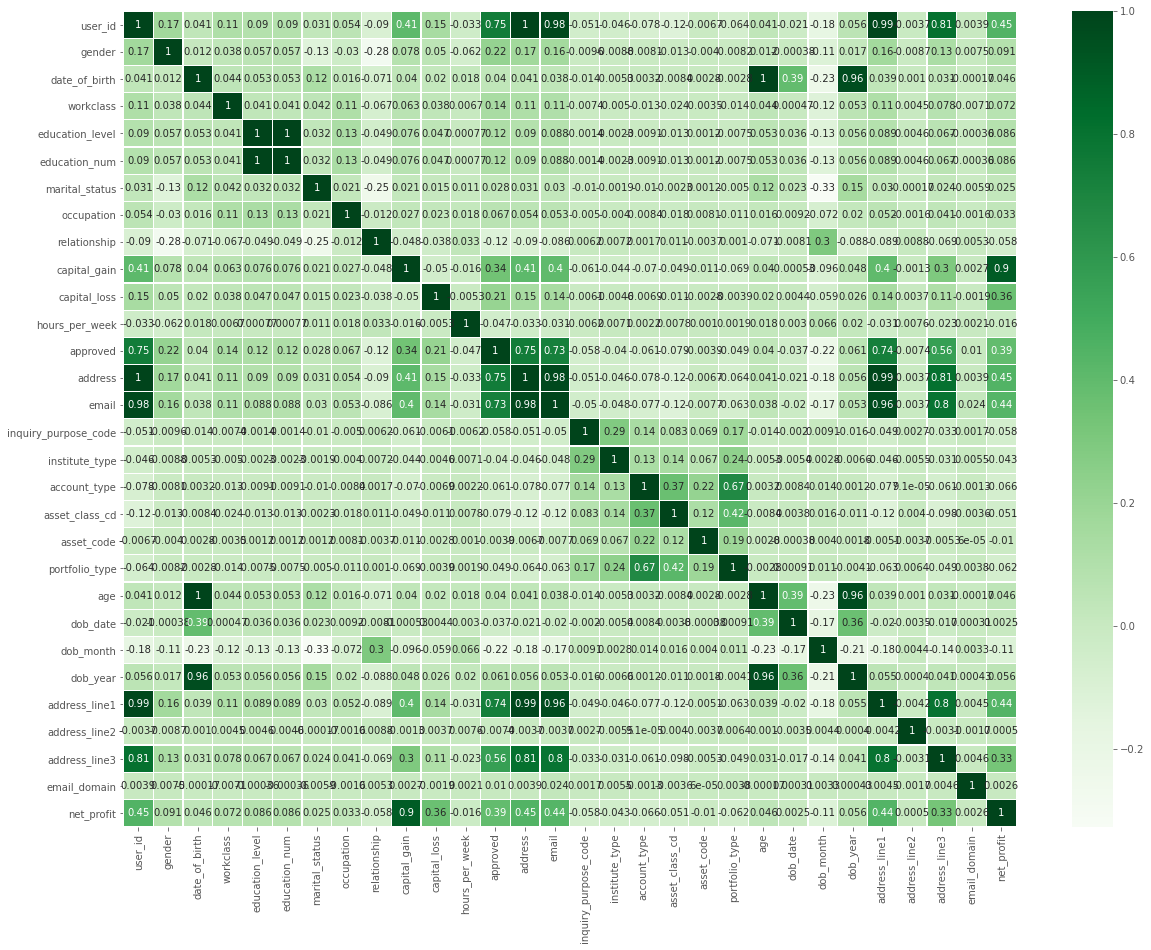

In [201]:
plt.figure(figsize=(20, 15))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2, cmap="Greens", annot =  True)

In [202]:
#dropping redundant columns
drop_columns= ["user_id", "date_of_birth", "education_level", "address", "address_line1", "address_line3", "email", "dob_date", "dob_month", "dob_year", "capital_gain", "capital_loss"]

In [203]:
df = df.drop(drop_columns, axis = 1)

In [204]:
df.isna().sum()

gender                      0
workclass                   0
education_num               0
marital_status              0
occupation                  0
relationship                0
hours_per_week              0
approved                    0
inquiry_purpose_code     1291
institute_type              0
account_type                0
asset_class_cd          35730
asset_code                 82
portfolio_type              6
age                         0
address_line2               0
email_domain                0
net_profit                  0
dtype: int64

In [205]:
cat_columns = [c for c in df.columns if df[c].dtype == 'object']

In [206]:
#handling missing values
df["asset_class_cd"] = df["asset_class_cd"].fillna("-1") # given in the problem statement 

In [217]:
#label encoding the data while still keeping the null values
df = df.apply(lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]),
                                       index=series[series.notnull()].index))

In [218]:
df.isna().sum()

gender                     0
workclass                  0
education_num              0
marital_status             0
occupation                 0
relationship               0
hours_per_week             0
approved                   0
inquiry_purpose_code    1291
institute_type             0
account_type               0
asset_class_cd             0
asset_code                82
portfolio_type             6
age                        0
address_line2              0
email_domain               0
net_profit                 0
dtype: int64

In [219]:
#using MissForest for data imputation
imputer = MissForest()
X = df.drop('approved', axis=1)
X_imputed = imputer.fit_transform(X)

df1 = pd.DataFrame(X_imputed, columns = X.columns)

df = pd.merge(df, df["approved"], left_index=True, right_index=True)

Iteration: 0
Iteration: 1
Iteration: 2


In [220]:
df.isna().sum()

gender                     0
workclass                  0
education_num              0
marital_status             0
occupation                 0
relationship               0
hours_per_week             0
approved                   0
inquiry_purpose_code    1291
institute_type             0
account_type               0
asset_class_cd             0
asset_code                82
portfolio_type             6
age                        0
address_line2              0
email_domain               0
net_profit                 0
dtype: int64

In [221]:
df["inquiry_purpose_code"] = df["inquiry_purpose_code"].round()
df["asset_code"] = df["asset_code"].round()
df["portfolio_type"] = df["portfolio_type"].round()

In [222]:
# converting the categorical column back as oobject datatype
for i in cat_columns:
    df[i] = df[i].astype(object)

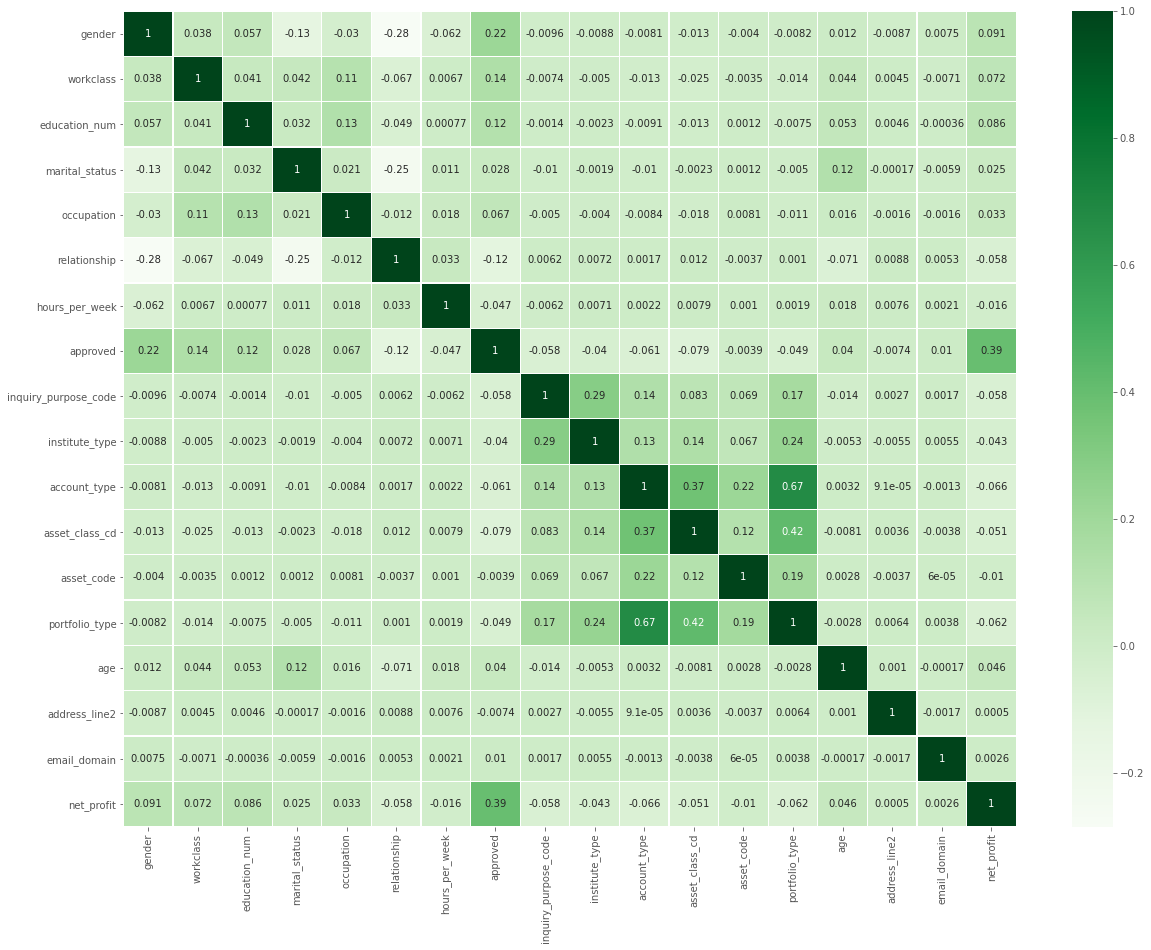

In [223]:
plt.figure(figsize=(20, 15))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2, cmap="Greens", annot =  True)

In [224]:
df.shape

(45222, 18)

In [225]:
data= df.copy()

In [226]:
categorical_cols = [c for c in df.columns if df[c].dtype == 'object']

for col in categorical_cols:
    if df[col].nunique() == 2:
        df[col], _ = pd.factorize(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first = True)

In [229]:
X, y = df.drop(["approved"], axis=1), df['approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify= df.approved, random_state = 45)

In [230]:
continuous_cols = ["education_num", "net_profit", "hours_per_week", "age"]

for col in continuous_cols:
    scaler = StandardScaler()
    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1,1))

In [231]:
def auc_roc_curve(model_name, ground_truth, probability_value):

    baseline = [0 for _ in range(len(ground_truth))]


    baseline_auc = roc_auc_score(ground_truth, baseline)
    model_roc_auc = roc_auc_score(ground_truth, probability_value)  

    print(f'Base line: ROC AUC = {baseline_auc}')
    print(f'{model_name}: ROC AUC = {model_roc_auc}')

    # calculating roc curves
    ns_fpr, ns_tpr, _ = roc_curve(ground_truth, baseline)
    lr_fpr, lr_tpr, _ = roc_curve(ground_truth, probability_value)

    # plotting the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)


    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [232]:
def plot_feature_importance(importance, names, model_type, k = 20):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    fi_df = fi_df[:k]
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' feature importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [233]:
def permutation_importances(model, X_train, y_train, metric):
    y_pred = model.predict_proba(X_train)[:, 1]
    baseline = metric(y_train, y_pred)
    
    imp = []
    for col in X.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        
        pred = model.predict_proba(X_train)[:, 1]
        m = metric(y_train, pred)
        X_train[col] = save
        imp.append(baseline - m)
        
    return np.array(imp)

Logistic Regression --> to create a baseline

In [234]:
logistic = linear_model.LogisticRegression(max_iter = 1000, class_weight = "balanced")

# Creating regularization penalty space and hyperparameter space
penalty = ['l1', 'l2']
solver = [ "newton-cg", "liblinear", "lbfgs" ]
C = np.logspace(0, 10, 50)

# Creating hyperparameter options
hyperparameters_log = dict(C=C, penalty=penalty,solver = solver)

In [236]:
# Creating and fitting grid search using 10-fold cross validation
grid_logistic = GridSearchCV(logistic, hyperparameters_log, cv = 2, verbose=2, n_jobs = -1)
grid_logistic.fit(X_train, y_train)

In [ ]:
grid_logistic.best_params_

In [ ]:
gridlogpredict = grid_logistic.predict(X_test)
print(classification_report(y_test,gridlogpredict))
print(confusion_matrix(y_test, gridlogpredict))

In [237]:
#Modeling the logistic classifier with the best parameters 

bestlogistic = LogisticRegression(C=1526417967.1752365, penalty='l2',solver = 'lbfgs' )  
bestlogistic.fit(X_train, y_train)
bestlogisticpredict = bestlogistic.predict(X_test)

print(classification_report(y_test,bestlogisticpredict))
print(confusion_matrix(y_test, bestlogisticpredict))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10205
           1       0.71      0.61      0.66      3362

    accuracy                           0.84     13567
   macro avg       0.79      0.77      0.78     13567
weighted avg       0.84      0.84      0.84     13567

[[9364  841]
 [1300 2062]]


In [238]:
probability_class_1 = bestlogistic.predict_proba(X_test)[:, 1] 

Base line: ROC AUC = 0.5
Logistic Regression: ROC AUC = 0.8978670596029462


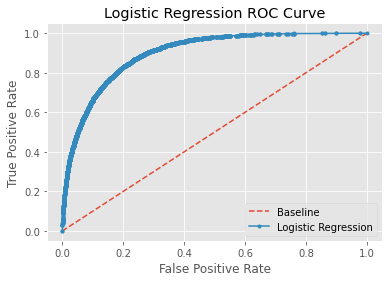

In [239]:
auc_roc_curve("Logistic Regression", y_test, probability_class_1)

In [240]:
print("Log-loss on Logistic Regression: {:6.4f}".format(log_loss(y_test, probability_class_1)))

Log-loss on Logistic Regression: 0.3386


In [241]:
lr_feature_importance = permutation_importances(bestlogistic, X_train, y_train, roc_auc_score )

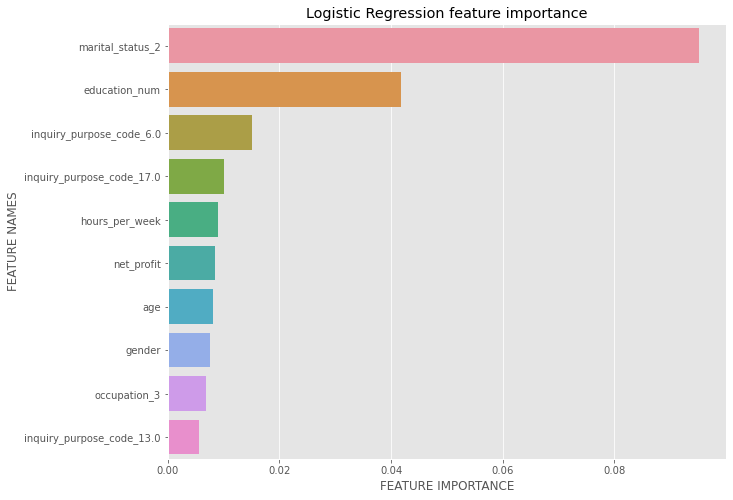

In [242]:
plot_feature_importance(lr_feature_importance, X.columns, "Logistic Regression", k = 10)

In [ ]:
#credit line

"""
Assigning a credit limit can be dependent on a lot of factors and since the credits provided here are not just on credit card.
I am instead calculating a CIBIL score to understand, how good the creditee is. which will help the lender to decode accordingly.

Factors involved:
    1. Loan amount
    2. Duration of loan
    3. Interest rate
    and so on...


"""

In [306]:
def get_original_columns(column_name):
    
    original_columns = data.columns
    for i in original_columns:
        if i in str(column_name):
            return i
    
    return column_name

In [307]:
# Creating a summary table of our logistic regression model
df_scorecard = pd.DataFrame(columns = ['Feature name'], data =  X_train.columns)
df_scorecard['Coefficients'] = np.transpose(bestlogistic.coef_)
df_scorecard.index = df_scorecard.index + 1
df_scorecard.loc[0] = ['Intercept', bestlogistic.intercept_[0]]
df_scorecard.sort_index(inplace = True)

In [308]:
df_scorecard["Original feature name"] = df_scorecard.apply(lambda x: get_original_columns(x["Feature name"]), axis = 1)

In [352]:
df_scorecard.head()

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,-3.263351,Intercept,558.725365,559.0,0.274635,558.0
1,gender,0.766800,gender,14.277839,14.0,-0.277839,14.0
2,education_num,0.760154,education_num,14.154074,14.0,-0.154074,14.0
3,hours_per_week,0.368951,hours_per_week,6.869877,7.0,0.130123,7.0
4,age,0.367792,age,6.848290,7.0,0.151710,7.0


In [310]:
#score card calculation
min_score = 350 
max_score = 800

In [311]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()

In [312]:
# create a new column that has the imputed calculated Score based scaled from the coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) /(max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

In [313]:
df_scorecard.head()

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,Intercept,-3.263351,Intercept,558.725365,559.0
1,gender,0.766800,gender,14.277839,14.0
2,education_num,0.760154,education_num,14.154074,14.0
3,hours_per_week,0.368951,hours_per_week,6.869877,7.0
4,age,0.367792,age,6.848290,7.0


In [314]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

351.0
801.0


In [315]:
# so both our min and max scores are out by +1. we need to manually adjust this
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']

# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 558


In [317]:
# Rechecking min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

350.0
800.0


In [ ]:
#calculating credit score for test set

In [318]:
X_test_new = X_test.copy()

X_test_new.insert(0, "Intercept", 1)

In [322]:
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(167, 1)

In [323]:
print(X_test_new.shape)
print(scorecard_scores.shape)

(13567, 167)
(167, 1)


In [324]:
y_scores = X_test_new.dot(scorecard_scores)

In [351]:
y_scores

,0
26119,575.200429
32187,489.583855
4554,618.261893
35892,594.005477
32093,594.972674
...,...
1909,566.666738
39165,645.171367
5110,520.822964
5526,584.592943


KNN Classifier

In [70]:
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
hyperparameters_knn = dict(n_neighbors=k_range)

grid_knn = GridSearchCV(knn, hyperparameters_knn, cv=2, verbose=2)
grid_knn.fit(X_train, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] END ......................................n_neighbors=1; total time=   1.5s
[CV] END ......................................n_neighbors=1; total time=   1.0s
[CV] END ......................................n_neighbors=2; total time=   1.2s
[CV] END ......................................n_neighbors=2; total time=   1.4s
[CV] END ......................................n_neighbors=3; total time=   1.2s
[CV] END ......................................n_neighbors=3; total time=   1.4s
[CV] END ......................................n_neighbors=4; total time=   2.1s
[CV] END ......................................n_neighbors=4; total time=   2.1s
[CV] END ......................................n_neighbors=5; total time=   1.8s
[CV] END ......................................n_neighbors=5; total time=   1.8s
[CV] END ......................................n_neighbors=6; total time=   1.0s
[CV] END ......................................n

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=2)

In [71]:
grid_knn.best_params_  

{'n_neighbors': 13}

In [72]:
grid_knn_predict = grid_knn.predict(X_test)
print(classification_report(y_test,grid_knn_predict))
print(confusion_matrix(y_test, grid_knn_predict))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     10205
           1       0.68      0.47      0.55      3362

    accuracy                           0.81     13567
   macro avg       0.76      0.70      0.72     13567
weighted avg       0.80      0.81      0.80     13567

[[9466  739]
 [1788 1574]]


In [179]:
#Modeling the classifier with the best parameters
modelbestknn = KNeighborsClassifier(n_neighbors = 13) 
modelbestknn.fit(X_train, y_train)
predictionbestknn = modelbestknn.predict(X_test)

print(classification_report(y_test,predictionbestknn))
print(confusion_matrix(y_test, predictionbestknn))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     10205
           1       0.70      0.63      0.66      3362

    accuracy                           0.84     13567
   macro avg       0.79      0.77      0.78     13567
weighted avg       0.84      0.84      0.84     13567

[[9301  904]
 [1250 2112]]


In [180]:
knnprobability_class_1 = modelbestknn.predict_proba(X_test)[:, 1]

Base line: ROC AUC = 0.5
K Nearest Neighbor: ROC AUC = 0.8895543937036148


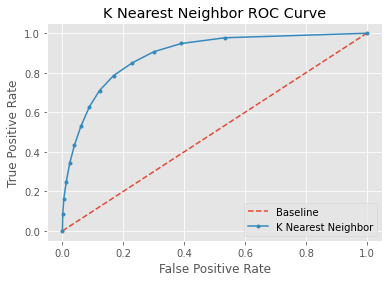

In [181]:
auc_roc_curve("K Nearest Neighbor", y_test, knnprobability_class_1)

Random Forest

In [76]:
rfc=RandomForestClassifier()

hyperparameters_rfc = { 
    'n_estimators': [100,150],
    'max_features': [None, 'log2', 'sqrt'],
    'max_depth' : list(range(3,10,1)),
    'criterion' :['gini', 'entropy']
}

grid_rfc = GridSearchCV(estimator=rfc, param_grid=hyperparameters_rfc, cv= 2, verbose=2)
grid_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 84 candidates, totalling 168 fits
[CV] END criterion=gini, max_depth=3, max_features=None, n_estimators=100; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=None, n_estimators=100; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=None, n_estimators=150; total time=   2.0s
[CV] END criterion=gini, max_depth=3, max_features=None, n_estimators=150; total time=   2.5s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100; total time=   1.0s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100; total time=   0.7s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=150; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=150; total time=   1.1s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.8s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.8

[CV] END criterion=entropy, max_depth=3, max_features=None, n_estimators=150; total time=   2.3s
[CV] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=150; total time=   1.1s
[CV] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=150; total time=   1.5s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=150; total time=   1.1s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=150; total time=   1.0s
[CV] END criterion=entropy, max_depth=4, max_features=None, n_estimators=100; total time=   1.8s
[CV] END criterion=entropy, ma

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'log2', 'sqrt'],
                         'n_estimators': [100, 150]},
             verbose=2)

In [77]:
grid_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'n_estimators': 100}

In [78]:
grid_rfc_predict = grid_rfc.predict(X_test)
print(classification_report(y_test,grid_rfc_predict))
print(confusion_matrix(y_test, grid_rfc_predict))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     10205
           1       0.79      0.56      0.66      3362

    accuracy                           0.85     13567
   macro avg       0.83      0.76      0.78     13567
weighted avg       0.85      0.85      0.85     13567

[[9698  507]
 [1470 1892]]


In [166]:
#Modeling the classifier with the best parameters
modelbestRFC = RandomForestClassifier(criterion = 'gini', max_depth= 9, max_features =None, n_estimators = 100) 
modelbestRFC.fit(X_train, y_train)
predictionbestRFC = modelbestRFC.predict(X_test)

print(classification_report(y_test, predictionbestRFC))
print(confusion_matrix(y_test, predictionbestRFC))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     10205
           1       0.78      0.60      0.68      3362

    accuracy                           0.86     13567
   macro avg       0.83      0.77      0.79     13567
weighted avg       0.85      0.86      0.85     13567

[[9641  564]
 [1355 2007]]


In [167]:
RFprobability_class_1 = modelbestRFC.predict_proba(X_test)[:, 1]

Base line: ROC AUC = 0.5
Random Forest: ROC AUC = 0.9142201175719289


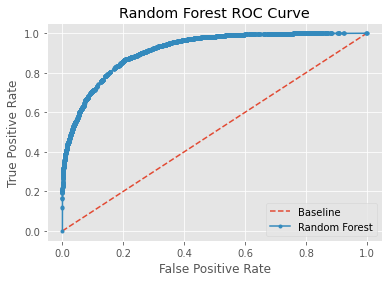

In [168]:
auc_roc_curve("Random Forest", y_test, RFprobability_class_1)

In [169]:
print("Log-loss on RF: {:6.4f}".format(log_loss(y_test, RFprobability_class_1)))

Log-loss on RF: 0.3038


In [170]:
feature_importance_ = permutation_importances(modelbestRFC, X_train, y_train, roc_auc_score)

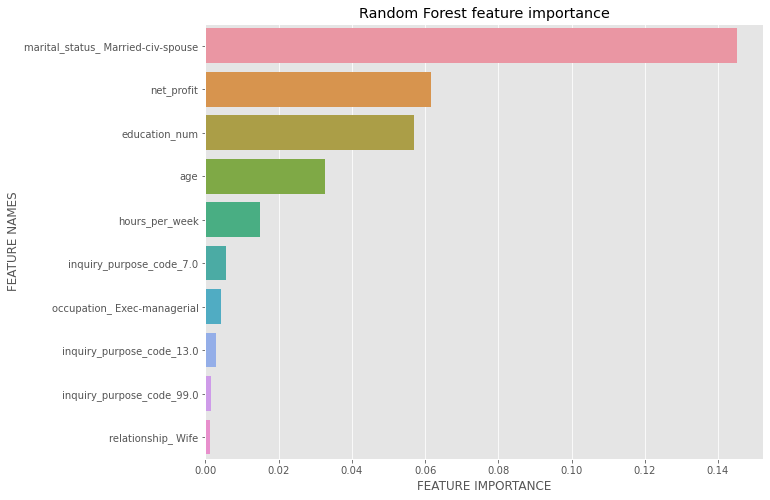

In [171]:
plot_feature_importance(feature_importance_, X.columns, 'Random Forest', k = 10)

Boosting Trees

In [85]:
abc = AdaBoostClassifier()

hyperparameters_abc = { 
    "base_estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
    'n_estimators': [100,150,200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}

grid_abc = GridSearchCV(estimator=abc, param_grid=hyperparameters_abc, cv= 2, verbose=2)
grid_abc.fit(X_train, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.0001, n_estimators=100; total time=   2.3s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.0001, n_estimators=100; total time=   2.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.0001, n_estimators=150; total time=   3.4s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.0001, n_estimators=150; total time=   3.0s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.0001, n_estimators=200; total time=   5.4s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.0001, n_estimators=200; total time=   5.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.001, n_estimators=100; total time=   3.4s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.001, n_estimators=100;

[CV] END base_estimator=DecisionTreeClassifier(max_depth=2), learning_rate=0.3, n_estimators=150; total time=   3.7s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=2), learning_rate=0.3, n_estimators=200; total time=   4.7s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=2), learning_rate=0.3, n_estimators=200; total time=   4.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.0001, n_estimators=100; total time=   2.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.0001, n_estimators=100; total time=   3.6s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.0001, n_estimators=150; total time=   5.1s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.0001, n_estimators=150; total time=   5.1s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.0001, n_estimators=200; total time=   6.2s
[CV] END base_estimator=DecisionTreeClassifier(ma

GridSearchCV(cv=2, estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                            DecisionTreeClassifier(max_depth=2),
                                            DecisionTreeClassifier(max_depth=3)],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [86]:
grid_abc.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=2),
 'learning_rate': 0.3,
 'n_estimators': 200}

In [87]:
grid_abc_predict = grid_abc.predict(X_test)
print(classification_report(y_test,grid_abc_predict))
print(confusion_matrix(y_test, grid_abc_predict))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     10205
           1       0.80      0.68      0.73      3362

    accuracy                           0.88     13567
   macro avg       0.85      0.81      0.83     13567
weighted avg       0.87      0.88      0.87     13567

[[9618  587]
 [1071 2291]]


In [172]:
#Modeling the classifier with the best parameters
modelbestABC = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=2), learning_rate= 0.3, n_estimators = 200) 
modelbestABC.fit(X_train, y_train)
predictionbestABC = modelbestABC.predict(X_test)

print(classification_report(y_test, predictionbestABC))
print(confusion_matrix(y_test, predictionbestABC))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     10205
           1       0.79      0.68      0.73      3362

    accuracy                           0.88     13567
   macro avg       0.85      0.81      0.83     13567
weighted avg       0.87      0.88      0.87     13567

[[9599  606]
 [1060 2302]]


In [173]:
ABprobability_class_1 = modelbestABC.predict_proba(X_test)[:, 1]

Base line: ROC AUC = 0.5
AdaBoost: ROC AUC = 0.9323537761434904


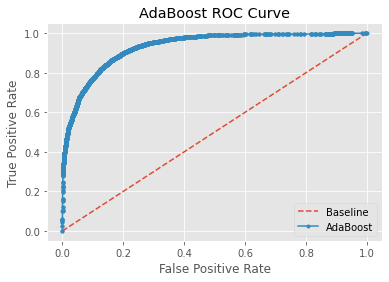

In [174]:
auc_roc_curve("AdaBoost", y_test, ABprobability_class_1)

In [175]:
print("Log-loss on RF: {:6.4f}".format(log_loss(y_test, ABprobability_class_1)))

Log-loss on RF: 0.6551


In [189]:
adaboost_feature_importance_ = permutation_importances(modelbestABC, X_train, y_train, roc_auc_score)

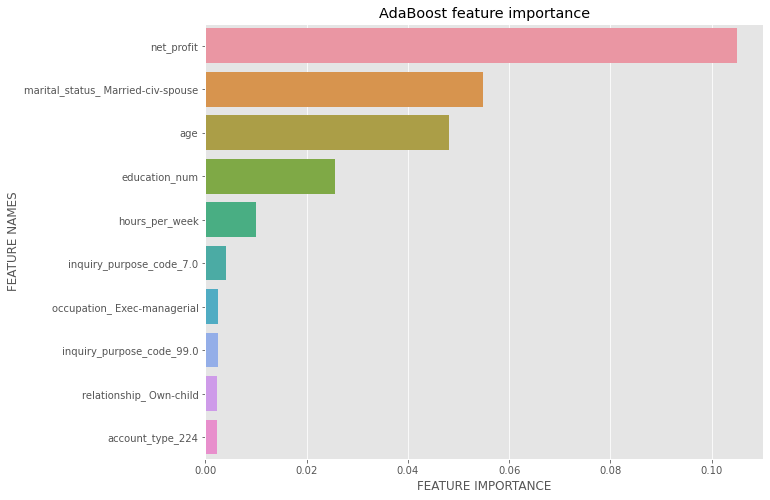

In [190]:
plot_feature_importance(adaboost_feature_importance_, X.columns, 'AdaBoost', k = 10)

In [ ]:
#catboost

In [94]:
cbc = CatBoostClassifier(loss_function='Logloss', eval_metric = 'AUC')

hyperparameters_cbc = {
    'depth': [4,5,6,7,8,9, 10],
    'learning_rate' : [0.01,0.02,0.03,0.04],
    'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
}
 
grid_cbc = GridSearchCV(estimator=cbc, param_grid=hyperparameters_cbc, cv= 2, n_jobs = -1)
grid_cbc.fit(X_train, y_train)

0:	total: 169ms	remaining: 16.7s
1:	total: 182ms	remaining: 8.92s
2:	total: 196ms	remaining: 6.34s
3:	total: 210ms	remaining: 5.04s
4:	total: 224ms	remaining: 4.25s
5:	total: 237ms	remaining: 3.71s
6:	total: 251ms	remaining: 3.33s
7:	total: 264ms	remaining: 3.04s
8:	total: 277ms	remaining: 2.8s
9:	total: 290ms	remaining: 2.61s
10:	total: 303ms	remaining: 2.45s
11:	total: 310ms	remaining: 2.27s
12:	total: 324ms	remaining: 2.17s
13:	total: 336ms	remaining: 2.07s
14:	total: 349ms	remaining: 1.98s
15:	total: 363ms	remaining: 1.91s
16:	total: 378ms	remaining: 1.84s
17:	total: 391ms	remaining: 1.78s
18:	total: 404ms	remaining: 1.72s
19:	total: 416ms	remaining: 1.66s
20:	total: 428ms	remaining: 1.61s
21:	total: 441ms	remaining: 1.56s
22:	total: 454ms	remaining: 1.52s
23:	total: 468ms	remaining: 1.48s
24:	total: 480ms	remaining: 1.44s
25:	total: 494ms	remaining: 1.4s
26:	total: 507ms	remaining: 1.37s
27:	total: 520ms	remaining: 1.33s
28:	total: 532ms	remaining: 1.3s
29:	total: 546ms	remaining:

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F0CB036C40>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [96]:
grid_cbc.best_params_

{'depth': 9, 'iterations': 100, 'learning_rate': 0.04}

In [97]:
grid_cbc_predict = grid_cbc.predict(X_test)
print(classification_report(y_test,grid_cbc_predict))
print(confusion_matrix(y_test, grid_cbc_predict))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     10205
           1       0.79      0.58      0.67      3362

    accuracy                           0.86     13567
   macro avg       0.83      0.77      0.79     13567
weighted avg       0.85      0.86      0.85     13567

[[9688  517]
 [1402 1960]]


In [183]:
#Modeling the classifier with the best parameters
modelbestCBC = CatBoostClassifier(loss_function='Logloss', eval_metric = 'AUC', verbose = True) 
modelbestCBC.fit(X_train, y_train)
predictionbestCBC = modelbestABC.predict(X_test)

print(classification_report(y_test, predictionbestCBC))
print(confusion_matrix(y_test, predictionbestCBC))

Learning rate set to 0.045043
0:	total: 142ms	remaining: 2m 21s
1:	total: 151ms	remaining: 1m 15s
2:	total: 162ms	remaining: 53.7s
3:	total: 173ms	remaining: 43s
4:	total: 185ms	remaining: 36.8s
5:	total: 196ms	remaining: 32.5s
6:	total: 208ms	remaining: 29.4s
7:	total: 220ms	remaining: 27.3s
8:	total: 232ms	remaining: 25.6s
9:	total: 242ms	remaining: 24s
10:	total: 251ms	remaining: 22.6s
11:	total: 260ms	remaining: 21.4s
12:	total: 269ms	remaining: 20.4s
13:	total: 277ms	remaining: 19.5s
14:	total: 285ms	remaining: 18.7s
15:	total: 294ms	remaining: 18.1s
16:	total: 304ms	remaining: 17.6s
17:	total: 313ms	remaining: 17.1s
18:	total: 322ms	remaining: 16.6s
19:	total: 332ms	remaining: 16.3s
20:	total: 341ms	remaining: 15.9s
21:	total: 352ms	remaining: 15.7s
22:	total: 366ms	remaining: 15.5s
23:	total: 383ms	remaining: 15.6s
24:	total: 396ms	remaining: 15.5s
25:	total: 411ms	remaining: 15.4s
26:	total: 425ms	remaining: 15.3s
27:	total: 439ms	remaining: 15.2s
28:	total: 454ms	remaining: 15

238:	total: 2.24s	remaining: 7.13s
239:	total: 2.25s	remaining: 7.12s
240:	total: 2.26s	remaining: 7.12s
241:	total: 2.27s	remaining: 7.11s
242:	total: 2.28s	remaining: 7.11s
243:	total: 2.29s	remaining: 7.1s
244:	total: 2.3s	remaining: 7.09s
245:	total: 2.31s	remaining: 7.09s
246:	total: 2.32s	remaining: 7.08s
247:	total: 2.33s	remaining: 7.08s
248:	total: 2.35s	remaining: 7.08s
249:	total: 2.36s	remaining: 7.08s
250:	total: 2.37s	remaining: 7.06s
251:	total: 2.38s	remaining: 7.06s
252:	total: 2.39s	remaining: 7.05s
253:	total: 2.4s	remaining: 7.04s
254:	total: 2.41s	remaining: 7.04s
255:	total: 2.42s	remaining: 7.04s
256:	total: 2.43s	remaining: 7.03s
257:	total: 2.44s	remaining: 7.03s
258:	total: 2.46s	remaining: 7.03s
259:	total: 2.46s	remaining: 7.02s
260:	total: 2.48s	remaining: 7.01s
261:	total: 2.49s	remaining: 7.01s
262:	total: 2.5s	remaining: 7s
263:	total: 2.51s	remaining: 6.99s
264:	total: 2.52s	remaining: 6.98s
265:	total: 2.53s	remaining: 6.97s
266:	total: 2.54s	remaining

490:	total: 4.53s	remaining: 4.69s
491:	total: 4.54s	remaining: 4.69s
492:	total: 4.55s	remaining: 4.68s
493:	total: 4.56s	remaining: 4.67s
494:	total: 4.57s	remaining: 4.66s
495:	total: 4.57s	remaining: 4.65s
496:	total: 4.58s	remaining: 4.63s
497:	total: 4.59s	remaining: 4.62s
498:	total: 4.59s	remaining: 4.61s
499:	total: 4.6s	remaining: 4.6s
500:	total: 4.61s	remaining: 4.59s
501:	total: 4.62s	remaining: 4.58s
502:	total: 4.63s	remaining: 4.57s
503:	total: 4.63s	remaining: 4.56s
504:	total: 4.64s	remaining: 4.55s
505:	total: 4.65s	remaining: 4.54s
506:	total: 4.66s	remaining: 4.53s
507:	total: 4.66s	remaining: 4.52s
508:	total: 4.67s	remaining: 4.5s
509:	total: 4.68s	remaining: 4.5s
510:	total: 4.68s	remaining: 4.48s
511:	total: 4.69s	remaining: 4.47s
512:	total: 4.7s	remaining: 4.46s
513:	total: 4.71s	remaining: 4.45s
514:	total: 4.72s	remaining: 4.44s
515:	total: 4.73s	remaining: 4.43s
516:	total: 4.73s	remaining: 4.42s
517:	total: 4.74s	remaining: 4.41s
518:	total: 4.75s	remaini

729:	total: 6.61s	remaining: 2.44s
730:	total: 6.62s	remaining: 2.43s
731:	total: 6.63s	remaining: 2.43s
732:	total: 6.64s	remaining: 2.42s
733:	total: 6.65s	remaining: 2.41s
734:	total: 6.66s	remaining: 2.4s
735:	total: 6.67s	remaining: 2.39s
736:	total: 6.68s	remaining: 2.38s
737:	total: 6.69s	remaining: 2.38s
738:	total: 6.71s	remaining: 2.37s
739:	total: 6.72s	remaining: 2.36s
740:	total: 6.73s	remaining: 2.35s
741:	total: 6.74s	remaining: 2.34s
742:	total: 6.76s	remaining: 2.34s
743:	total: 6.77s	remaining: 2.33s
744:	total: 6.78s	remaining: 2.32s
745:	total: 6.79s	remaining: 2.31s
746:	total: 6.8s	remaining: 2.3s
747:	total: 6.81s	remaining: 2.29s
748:	total: 6.83s	remaining: 2.29s
749:	total: 6.84s	remaining: 2.28s
750:	total: 6.85s	remaining: 2.27s
751:	total: 6.86s	remaining: 2.26s
752:	total: 6.87s	remaining: 2.25s
753:	total: 6.88s	remaining: 2.24s
754:	total: 6.89s	remaining: 2.23s
755:	total: 6.9s	remaining: 2.23s
756:	total: 6.91s	remaining: 2.22s
757:	total: 6.92s	remain

966:	total: 8.71s	remaining: 297ms
967:	total: 8.72s	remaining: 288ms
968:	total: 8.72s	remaining: 279ms
969:	total: 8.73s	remaining: 270ms
970:	total: 8.74s	remaining: 261ms
971:	total: 8.75s	remaining: 252ms
972:	total: 8.76s	remaining: 243ms
973:	total: 8.77s	remaining: 234ms
974:	total: 8.77s	remaining: 225ms
975:	total: 8.78s	remaining: 216ms
976:	total: 8.79s	remaining: 207ms
977:	total: 8.8s	remaining: 198ms
978:	total: 8.81s	remaining: 189ms
979:	total: 8.82s	remaining: 180ms
980:	total: 8.83s	remaining: 171ms
981:	total: 8.84s	remaining: 162ms
982:	total: 8.85s	remaining: 153ms
983:	total: 8.86s	remaining: 144ms
984:	total: 8.87s	remaining: 135ms
985:	total: 8.88s	remaining: 126ms
986:	total: 8.89s	remaining: 117ms
987:	total: 8.9s	remaining: 108ms
988:	total: 8.91s	remaining: 99.1ms
989:	total: 8.92s	remaining: 90.1ms
990:	total: 8.92s	remaining: 81.1ms
991:	total: 8.93s	remaining: 72.1ms
992:	total: 8.94s	remaining: 63.1ms
993:	total: 8.95s	remaining: 54ms
994:	total: 8.96s	

In [184]:
CBprobability_class_1 = modelbestCBC.predict_proba(X_test)[:, 1]

Base line: ROC AUC = 0.5
CatBoost: ROC AUC = 0.9345858007223133


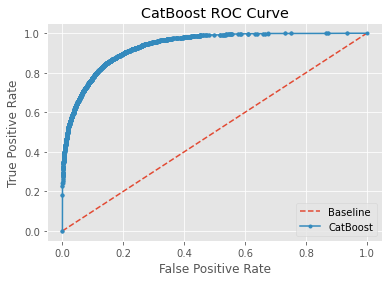

In [185]:
auc_roc_curve("CatBoost", y_test, CBprobability_class_1)

In [186]:
print("Log-loss on RF: {:6.4f}".format(log_loss(y_test, CBprobability_class_1)))

Log-loss on RF: 0.2697


In [191]:
catboost_feature_importance_ = permutation_importances(modelbestCBC, X_train, y_train, roc_auc_score)

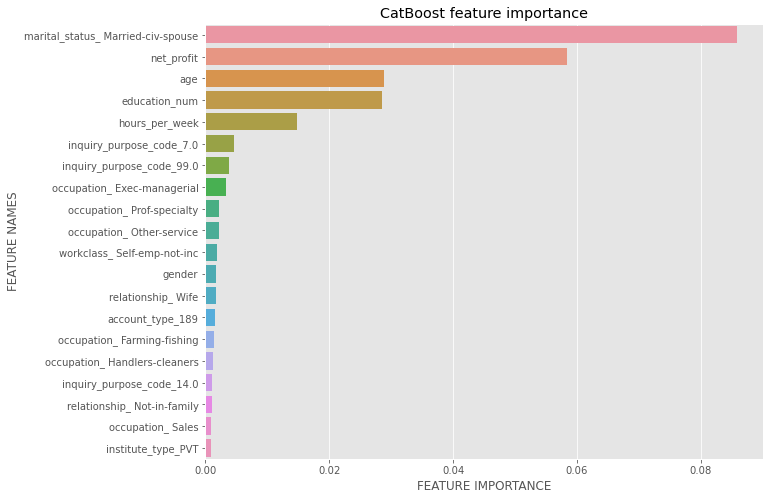

In [192]:
plot_feature_importance(catboost_feature_importance_, X.columns, 'CatBoost')

overall model comparision

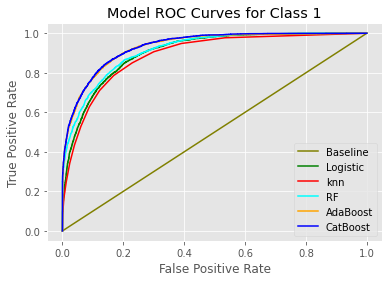

In [188]:
baseline = [0 for _ in range(len(y_test))]
lr_roc_auc = roc_auc_score(y_test, probability_class_1)
knn_roc_auc = roc_auc_score(y_test, knnprobability_class_1)
RF_roc_auc = roc_auc_score(y_test, RFprobability_class_1)
AB_roc_auc = roc_auc_score(y_test, ABprobability_class_1)
CB_roc_auc = roc_auc_score(y_test, CBprobability_class_1)

#roc curves
baseline_fpr, baseline_tpr, _  = roc_curve(y_test, baseline)
lr_fpr, lr_tpr, _ = roc_curve(y_test, probability_class_1)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knnprobability_class_1)
RF_fpr, RF_tpr, _ = roc_curve(y_test, RFprobability_class_1)
AB_fpr, AB_tpr, _ = roc_curve(y_test, ABprobability_class_1)
CB_fpr, CB_tpr, _ = roc_curve(y_test, CBprobability_class_1)


# plotting the roc curve for the model
plt.plot(baseline_fpr, baseline_tpr, color='olive', label='Baseline')
plt.plot(lr_fpr, lr_tpr, color='green', label='Logistic')
plt.plot(knn_fpr, knn_tpr, color='red', label='knn')
plt.plot(RF_fpr, RF_tpr, color='cyan', label='RF')
plt.plot(AB_fpr, AB_tpr, color='orange', label='AdaBoost')
plt.plot(CB_fpr, CB_tpr, color='blue', label='CatBoost')


plt.title('Model ROC Curves for Class 1');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()